In [1]:
!unzip Dataset1.zip

Archive:  Dataset1.zip
   creating: Dataset/fake/
  inflating: Dataset/fake/aagfhgtpmv_0.png  
  inflating: Dataset/fake/aagfhgtpmv_1.png  
  inflating: Dataset/fake/aagfhgtpmv_2.png  
  inflating: Dataset/fake/aagfhgtpmv_3.png  
  inflating: Dataset/fake/aagfhgtpmv_4.png  
  inflating: Dataset/fake/aagfhgtpmv_5.png  
  inflating: Dataset/fake/aagfhgtpmv_6.png  
  inflating: Dataset/fake/aagfhgtpmv_7.png  
  inflating: Dataset/fake/aagfhgtpmv_8.png  
  inflating: Dataset/fake/aagfhgtpmv_9.png  
  inflating: Dataset/fake/aapnvogymq_0.png  
  inflating: Dataset/fake/aapnvogymq_1.png  
  inflating: Dataset/fake/aapnvogymq_2.png  
  inflating: Dataset/fake/aapnvogymq_3.png  
  inflating: Dataset/fake/aapnvogymq_4.png  
  inflating: Dataset/fake/aapnvogymq_5.png  
  inflating: Dataset/fake/aapnvogymq_6.png  
  inflating: Dataset/fake/aapnvogymq_7.png  
  inflating: Dataset/fake/aapnvogymq_8.png  
  inflating: Dataset/fake/aapnvogymq_9.png  
  inflating: Dataset/fake/abqwwspghj_0.png  
  inf

In [ ]:
pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.1/39.5 MB 113.0 kB/s eta 0:05:49
   ---------------------------------------- 0.1/39.5 MB 180.8 kB/s eta 0:03:38
   ------

In [2]:
import os
import cv2
import numpy as np

# Define paths for real and fake image categories
real_dir = '/content/Dataset/real'
fake_dir = '/content/Dataset/fake'

# Function to load grayscale images and convert them into feature vectors
def extract_image_data(directory, label_value):
    extracted = []
    for file in os.listdir(directory):
        if file.lower().endswith('.png'):
            full_path = os.path.join(directory, file)
            image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                flattened = image.reshape(-1)
                extracted.append((flattened, label_value))
    return extracted

# Collect image data with corresponding labels (1 = real, 0 = fake)
real_images = extract_image_data(real_dir, 1)
fake_images = extract_image_data(fake_dir, 0)

# Merge and format dataset
dataset = real_images + fake_images
X = np.array([features for features, _ in dataset])
y = np.array([label for _, label in dataset])


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       231
           1       0.71      0.70      0.71       228

    accuracy                           0.71       459
   macro avg       0.71      0.71      0.71       459
weighted avg       0.71      0.71      0.71       459

Confusion Matrix:
 [[167  64]
 [ 68 160]]


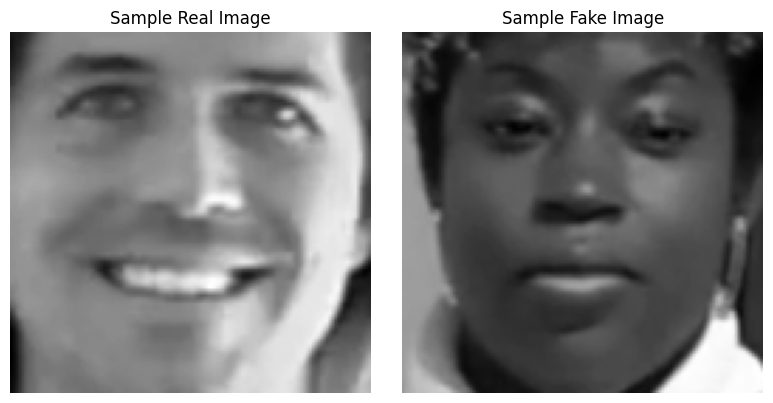

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# === LBP Feature Extraction ===
def compute_lbp(img):
    height, width = img.shape
    result = np.zeros((height, width), dtype=np.uint8)

    for row in range(1, height - 1):
        for col in range(1, width - 1):
            center_pixel = img[row, col]
            binary_str = ''
            neighbors = [
                img[row - 1, col - 1], img[row - 1, col], img[row - 1, col + 1],
                img[row, col + 1], img[row + 1, col + 1], img[row + 1, col],
                img[row + 1, col - 1], img[row, col - 1]
            ]
            for neighbor in neighbors:
                binary_str += '1' if neighbor >= center_pixel else '0'
            result[row, col] = int(binary_str, 2)

    return result

# === Load and Process Dataset ===
def process_images(directory, label_value, target_size=(128, 128)):
    feature_vectors = []
    label_list = []
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, target_size)
            lbp_map = compute_lbp(image)
            histogram, _ = np.histogram(lbp_map.flatten(), bins=256, range=(0, 256), density=True)
            feature_vectors.append(histogram)
            label_list.append(label_value)
    return feature_vectors, label_list

# === Dataset Paths ===
real_dir = "/content/Dataset/real"
fake_dir = "/content/Dataset/fake"

# === Feature Extraction ===
real_X, real_y = process_images(real_dir, 1)
fake_X, fake_y = process_images(fake_dir, 0)

X = np.array(real_X + fake_X)
y = np.array(real_y + fake_y)

# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === Train Model ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === Evaluate Performance ===
predictions = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

# === Visual Inspection (Optional) ===
def show_example_images(real_path, fake_path):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    real_img = cv2.imread(os.path.join(real_path, os.listdir(real_path)[0]), cv2.IMREAD_GRAYSCALE)
    fake_img = cv2.imread(os.path.join(fake_path, os.listdir(fake_path)[0]), cv2.IMREAD_GRAYSCALE)

    axes[0].imshow(cv2.resize(real_img, (128, 128)), cmap='gray')
    axes[0].set_title("Sample Real Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.resize(fake_img, (128, 128)), cmap='gray')
    axes[1].set_title("Sample Fake Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

show_example_images(real_dir, fake_dir)


In [6]:
import joblib

save_path = 'random_forest_model.pkl'

# To save the trained model for later use
joblib.dump(model, save_path)
print(f"Trained Random Forest model successfully saved at: {save_path}")


Trained Random Forest model successfully saved at: random_forest_model.pkl


In [7]:
import cv2
import numpy as np
import joblib

# Custom implementation of Local Binary Pattern (LBP)
def extract_lbp_features(gray_img):
    result = np.zeros_like(gray_img)
    for row in range(1, gray_img.shape[0] - 1):
        for col in range(1, gray_img.shape[1] - 1):
            center_pixel = gray_img[row, col]
            binary_string = ''
            neighbors = [
                gray_img[row-1, col-1], gray_img[row-1, col], gray_img[row-1, col+1],
                gray_img[row, col+1], gray_img[row+1, col+1], gray_img[row+1, col],
                gray_img[row+1, col-1], gray_img[row, col-1]
            ]
            for neighbor in neighbors:
                binary_string += '1' if neighbor >= center_pixel else '0'
            result[row, col] = int(binary_string, 2)
    return result

# Function to predict whether the given face is real or fake
def classify_face(image_path, model_file='random_forest_model.pkl'):
    try:
        model = joblib.load(model_file)
    except FileNotFoundError:
        print("Trained model file not found.")
        return

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Could not read the image.")
        return

    resized = cv2.resize(image, (128, 128))
    lbp_result = extract_lbp_features(resized)
    histogram, _ = np.histogram(lbp_result.ravel(), bins=256, range=(0, 256), density=True)
    features = histogram.reshape(1, -1)

    prediction = model.predict(features)[0]
    outcome = "Fake" if prediction == 1 else "Real"
    print(f"The model predicts this face is: {outcome}")


In [20]:
classify_face('/content/Dataset/fake/aagfhgtpmv_4.png')

The model predicts this face is: Fake
